In [10]:
elastic_rods_dir = '../../elastic_rods/python/'
weaving_dir = '../'
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
import copy

# Reloadable libraries
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (initialize_linkage, 
                                   update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj)
from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

In [11]:
# Sphere Parameters
default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
RIBBON_CS = [1, 10]
ISO_CS = [4, 4]
MODEL_PATH = osp.join(weaving_dir + 'models/equal_edge_atI.obj')
SUBDIVISION_RESOLUTION = 20
REGULARIZATION_WEIGHT = 0.05
RIBBON_NAME = 'sphere_ribbon'

In [12]:
# # Ellipsoidal Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [1, 10]
# ISO_CS = [4, 4]
# MODEL_PATH = osp.join(weaving_dir + 'models/ellipsoidal_from_equal_edge_atI.obj')
# SUBDIVISION_RESOLUTION = 40

In [13]:
# # Torus Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [0.1, 3]
# ISO_CS = [1, 1]
# MODEL_PATH = osp.join(weaving_dir + 'models/tri_hex_torus_linkage.obj')
# SUBDIVISION_RESOLUTION = 10
# REGULARIZATION_WEIGHT = 1

In [14]:
# # Squid Parameters
# default_camera_parameters = ((2.6356424863754238, -0.4503969385962889, 1.3527994896953035),(-0.0537660776573421, 0.07656413210907485, 0.9956569100687859),(0.12136370840743856, -0.04524672040635298, 0.06655322162019965))
# RIBBON_CS = [0.1, 2]
# ISO_CS = [1, 1]
# MODEL_PATH = osp.join(weaving_dir + 'models/squidward_linkage.obj')
# SUBDIVISION_RESOLUTION = 10

In [15]:
# # Lilium Parameters
# default_camera_parameters = ((0.8907837881925612, 3.554307138040378, 1.4585166237242706),
#  (0.10333453297616785, 0.020385552123086598, 0.9944807406678229),
#  (0.12136370840743856, -0.04524672040635298, 0.06655322162019965))
# RIBBON_CS = [0.1, 1]
# ISO_CS = [1, 1]
# MODEL_PATH = osp.join(weaving_dir + 'models/lilium_aux_max_3D_linkage.obj')
# SUBDIVISION_RESOLUTION = 10

In [16]:
# # Pseudosphere
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [0.001, 0.01]
# ISO_CS = [0.01, 0.01]
# MODEL_NAME = "pseudo_sphere"
# MODEL_PATH = osp.join(weaving_dir + 'models/{}.obj'.format(MODEL_NAME))
# SUBDIVISION_RESOLUTION = 10
# REGULARIZATION_WEIGHT = 0.00001

In [17]:
# # Florin torus Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [1, 10]
# ISO_CS = [4, 4]
# MODEL_PATH = osp.join(weaving_dir + 'models/centered_florin_torus.obj')
# SUBDIVISION_RESOLUTION = 20

## Model with Straight Weaver

In [18]:
with so(): straight_weaver_linkage, straight_weaver_view = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION)
export_linkage_geometry_to_obj(straight_weaver_linkage, 'sphere_straight.obj')
# straight_weaver_view.update(scalarField=get_distance_to_center_scalar_field(pentagon_linkage))
straight_weaver_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [19]:
print(straight_weaver_linkage.segment(0).rod.numEdges())
offset = 0;
centerline_count = 0;
m_dofOffsetForCenterlinePos = []
for i in range(straight_weaver_linkage.numSegments()):
#     m_dofOffsetForSegment[i] = offset;
    for j in range(straight_weaver_linkage.segment(i).rod.numVertices()):
        m_dofOffsetForCenterlinePos.append(offset + 3 * j)
        centerline_count += 1;
    offset += straight_weaver_linkage.segment(i).rod.numDoF()

print(m_dofOffsetForCenterlinePos[:40])
print(len(straight_weaver_linkage.deformedPoints()))
# for i in range(len(straight_weaver_linkage.deformedPoints())):
#     print(straight_weaver_linkage.dofOffsetForCenterlinePos(i))

20
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137]
3780


## "Fixed Point Iteration" for Optimizing Geodesic Curvature

In [21]:
with so(): start_linkage, start_view = initialize_linkage(model_path = MODEL_PATH, cross_section = ISO_CS, subdivision_res=SUBDIVISION_RESOLUTION)
# compare_turning_angle(start_linkage, esp = 0, remove_zeros = True)
start_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [25]:
curr_linkage = copy.deepcopy(start_linkage)
curr_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = False)
# with so():
#     elastic_rods.restlen_solve(curr_linkage)
#     elastic_rods.compute_equilibrium(curr_linkage, fixedVars=curr_linkage.jointPositionDoFIndices())
# view = linkage_vis.LinkageViewer(curr_linkage, width=1024, height=640)
# view.setCameraParams(default_camera_parameters)
# view.update(scalarField=get_distance_to_center_scalar_field(curr_linkage))
# view.show()

RuntimeError: make_tuple(): unable to convert argument of type 'RodLinkage_T<double>::Joint::Type' to Python object

In [26]:
with so():
    for i in range(20):
        curr_linkage = update_rest_curvature(curr_linkage)
#     Visualization
#     compare_turning_angle(curr_linkage, rest_linkage = prev_linkage)
#     prev_linkage = copy.deepcopy(curr_linkage)
#     view.update(scalarField=get_distance_to_center_scalar_field(curr_linkage))
#     input("Press Enter to continue...")



NameError: name 'curr_linkage' is not defined

In [ ]:
# design_linkage = copy.deepcopy(curr_linkage)
# design_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
# with so(): 
#     elastic_rods.designParameter_solve(design_linkage, regularization_weight = 0)
#     jdo = design_linkage.dofOffsetForJoint(driver)
#     fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
#     elastic_rods.compute_equilibrium(design_linkage, fixedVars=fixedVars)
# view = linkage_vis.LinkageViewer(design_linkage, width=1024, height=640)
# view.setCameraParams(default_camera_parameters)

## Experiments with resolution and regularization weight

In [15]:
# weight_list = np.logspace(-3, -1, num = 5)
# resolution_list = [5, 10, 20, 40]
# print(weight_list)

# for iw, weight in enumerate(weight_list):
#     for jr, res in enumerate(resolution_list):
#         with so(): 
#             start_linkage, _ = initialize_linkage(model_path = MODEL_PATH, cross_section = ISO_CS, subdivision_res=res)
#             curr_linkage = copy.deepcopy(start_linkage)
#             curr_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = False)
#             for i in range(20):
#                 curr_linkage = update_rest_curvature(curr_linkage)
#             linkage = copy.deepcopy(curr_linkage)
#             linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
#             elastic_rods.designParameter_solve(linkage, regularization_weight = weight)
#             driver=linkage.centralJoint()
#             jdo = linkage.dofOffsetForJoint(driver)
#             fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
#             elastic_rods.compute_equilibrium(linkage, fixedVars=fixedVars)
#         export_linkage_geometry_to_obj(linkage, 'mesh_results/{}_{}_sphere.obj'.format(str(np.around(weight, decimals=5)), res))

## Visualizing the model with Optimized Curved Weaver

In [27]:
free_joint_linkage = copy.deepcopy(start_linkage)
free_joint_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
driver=free_joint_linkage.centralJoint()
jdo = free_joint_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(free_joint_linkage, fixedVars=fixedVars)
view = linkage_vis.LinkageViewer(free_joint_linkage, width=1024, height=640)
view.setCameraParams(default_camera_parameters)
view.show()

RuntimeError: make_tuple(): unable to convert argument of type 'RodLinkage_T<double>::Joint::Type' to Python object

In [23]:
view.update(scalarField=get_distance_to_center_scalar_field(free_joint_linkage))
view.update(vectorField=[np.reshape(s.rod.gradient()[0:3*s.rod.numVertices()], (s.rod.numVertices(), 3)) for s in free_joint_linkage.segments()])

NameError: name 'view' is not defined

### Compare fixed point iteration results with design parameter solve results

In [18]:
with so(): 
    free_joint_linkage.setDoFs(curr_linkage.getDoFs()) 
    elastic_rods.designParameter_solve(free_joint_linkage, regularization_weight = 1)
    jdo = free_joint_linkage.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(free_joint_linkage, fixedVars=fixedVars)
view.update(preserveExisting=False)

In [19]:
export_linkage_geometry_to_obj(free_joint_linkage, 'sphere_design_parameter_solve.obj')

### Compare initialized from graph with intiailized from fixed point iteration

In [20]:
def initialize_linkage(cross_section = ISO_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH, cam_param = default_camera_parameters, regularization_weight = 0.1):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    driver=l.centralJoint()
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    l.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    elastic_rods.designParameter_solve(l, regularization_weight = regularization_weight)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    view.setCameraParams(cam_param)
    return l, view

with so(): init_from_graph_linkage, view = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, regularization_weight = REGULARIZATION_WEIGHT)
    
with so(): 
    init_from_graph_linkage = copy.deepcopy(curr_linkage)
    elastic_rods.designParameter_solve(init_from_graph_linkage, regularization_weight = 1)
    jdo = init_from_graph_linkage.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(init_from_graph_linkage, fixedVars=fixedVars)
view.update(preserveExisting=False)

In [21]:
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

#### Check normals of the linkage

In [22]:
# r = free_joint_linkage.segment(0).rod

In [23]:
# df = r.deformedConfiguration()
# vertices = []
# for i in range(free_joint_linkage.numSegments()):
#     vertices.extend(free_joint_linkage.segment(i).rod.deformedPoints())
# vertices = np.array(vertices)
# average_point = np.sum(vertices, axis=0) / vertices.shape[0]
# print(average_point)

In [24]:
# # print(len(df.materialFrame))
# # print(len(r.deformedPoints()))
# for i in range(len(r.deformedPoints()) - 1):
#     normal = r.deformedPoints()[i] - average_point
#     axis = df.materialFrame[i].d2
# #     print(np.dot(normal, axis) / la.norm(normal) / la.norm(axis))
    

#### Compare Straight Weaver and Curved Weaver

In [25]:
# compare_linkage = straight_weaver_linkage
# compare_view = linkage_vis.LinkageViewer(compare_linkage, width = 1024, height = 640)
# compare_view.update(preserveExisting=True, mesh = free_joint_linkage)
# compare_view.setCameraParams(default_camera_parameters)
# compare_view.show()

straight_linkage_geometry = straight_weaver_linkage.visualizationGeometry()
curved_weaver_linkage_geometry = free_joint_linkage.visualizationGeometry()
transformed_straight_linkage_geometry, _, _ = compute_min_distance_rigid_transformation(straight_linkage_geometry[0], curved_weaver_linkage_geometry[0])
# Visualize the linkage after transformed geometry
compare_straight_curve_view, compare_straight_curve_mesh = mesh_vis.get_mesh_viewer(transformed_straight_linkage_geometry, straight_linkage_geometry[1], straight_linkage_geometry[2])
compare_straight_curve_mesh.updateGeometry(*curved_weaver_linkage_geometry)
compare_straight_curve_view.update(preserveExisting=True)
compare_straight_curve_view.setCameraParams(default_camera_parameters)
compare_straight_curve_view.show()

109997.89974838495


Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

#### Compare Fixed Joint with Free Joint

In [26]:
curr_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
fixed_linkage_geometry = curr_linkage.visualizationGeometry()
curved_weaver_linkage_geometry = free_joint_linkage.visualizationGeometry()
transformed_fixed_linkage_geometry, _, _ = compute_min_distance_rigid_transformation(fixed_linkage_geometry[0], curved_weaver_linkage_geometry[0])
# Visualize the linkage after transformed geometry
compare_fixed_free_view, compare_fixed_free_mesh = mesh_vis.get_mesh_viewer(transformed_fixed_linkage_geometry, fixed_linkage_geometry[1], fixed_linkage_geometry[2])
compare_fixed_free_mesh.updateGeometry(*curved_weaver_linkage_geometry)
compare_fixed_free_view.update(preserveExisting=True)
compare_fixed_free_view.setCameraParams(default_camera_parameters)
compare_fixed_free_view.show()

21571.51089705527


Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [28]:
strips = order_segments_by_strips(curr_linkage)
all_strip_angle, all_strip_edge_len, _, _ = get_turning_angle_and_length_from_ordered_rods(strips, curr_linkage, rest = True)
# # Visualize all strips
# for i in range(len(all_strip_angle)):
# #     plot_curvatures(original = all_strip_angle[i], original_lengths = all_strip_edge_len[i])
#     xs, ys = get_curve_from_angle(all_strip_angle[i], all_strip_edge_len[i])


In [29]:
# with so():
#     elastic_rods.restlen_solve(curr_linkage)
#     elastic_rods.compute_equilibrium(curr_linkage, fixedVars=curr_linkage.jointPositionDoFIndices())
# view = linkage_vis.LinkageViewer(curr_linkage, width=1024, height=640)
# view.setCameraParams(default_camera_parameters)
# view.update(scalarField=get_distance_to_center_scalar_field(curr_linkage))
# view.show()

## Simulate a Single Weaver from the Linkage

In [30]:
new_rod, fixedVars = construct_elastic_rod_loop_from_rod_segments(free_joint_linkage, strips[1])
# Set the material of the new rod to be the same as previously.
new_rod.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
single_rod_view = linkage_vis.LinkageViewer(new_rod, width=1024, height=640)
input_geometry = new_rod.visualizationGeometry()
with so():
#     elastic_rods.restlen_solve(new_rod, fixedVars=fixedVars)
    elastic_rods.compute_equilibrium(new_rod, fixedVars=fixedVars)
equilibrium_geometry = new_rod.visualizationGeometry()
transformed_input, translation, rotation_matrix = compute_min_distance_rigid_transformation(input_geometry[0], equilibrium_geometry[0])

1528.9590378850698


In [31]:
# max_deviations = []
# print(len(strips))
# with so():
#     for i in range(len(strips)):
#         new_rod, fixedVars = construct_elastic_rod_loop_from_rod_segments(free_joint_linkage, strips[3])
#         # Set the material of the new rod to be the same as previously.
#         new_rod.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
#         single_rod_view = linkage_vis.LinkageViewer(new_rod, width=1024, height=640)
#         input_geometry = new_rod.visualizationGeometry()
#         with so():
#             elastic_rods.compute_equilibrium(new_rod, fixedVars=fixedVars)
#         equilibrium_geometry = new_rod.visualizationGeometry()
#         transformed_input, translation, rotation_matrix = compute_min_distance_rigid_transformation(input_geometry[0], equilibrium_geometry[0])
#     #     fig, axs = plt.subplots(2, 1)
#         # Centerline deviation
#         centerline_deviations = [la.norm(point) for point in np.array(new_rod.deformedPoints()) - np.array(new_rod.restPoints())]
# #         axs[0].plot(centerline_deviations)
#         # Geometry deviation
#         geometry_deviations = [la.norm(point) for point in equilibrium_geometry[0] - input_geometry[0]]
#     #     axs[1].plot(geometry_deviations)
#         # Geometry deviation after registration transformation
#         registration_deviations = [la.norm(point) for point in equilibrium_geometry[0] - transformed_input]
#     #     axs[1].plot(registration_deviations)
#     #     plt.show()
#         max_deviations.append(np.max(registration_deviations))
# print('Max deviation: ', max(max_deviations))

In [32]:
# Visualize the rod before and after compute_equilibrium
single_rod_view.setCameraParams(default_camera_parameters)
# single_rod_view.update(scalarField=deviations)
# single_rod_view.update(scalarField = new_rod.gradient()[-new_rod.numEdges():])
# single_rod_view.update(preserveExisting=True)
# plt.plot(new_rod.gradient()[-new_rod.numEdges():])
# single_rod_view.update(vectorField=[director.d1 for director in new_rod.deformedConfiguration().materialFrame])
# single_rod_view.update(vectorField=np.reshape(new_rod.gradient()[0:3*new_rod.numVertices()], (new_rod.numVertices(), 3)))
single_rod_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

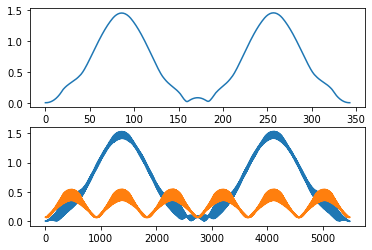

Max deviation:  0.5462397


In [33]:
fig, axs = plt.subplots(2, 1)
# Centerline deviation
centerline_deviations = [la.norm(point) for point in np.array(new_rod.deformedPoints()) - np.array(new_rod.restPoints())]
axs[0].plot(centerline_deviations)
# Geometry deviation
geometry_deviations = [la.norm(point) for point in equilibrium_geometry[0] - input_geometry[0]]
axs[1].plot(geometry_deviations)
# Geometry deviation after registration transformation
registration_deviations = [la.norm(point) for point in equilibrium_geometry[0] - transformed_input]
axs[1].plot(registration_deviations)
plt.show()
print('Max deviation: ', np.max(registration_deviations))

In [34]:
# Visualize the rod after transformed geometry
input_viewer, input_mesh = mesh_vis.get_mesh_viewer(*equilibrium_geometry)
# input_mesh.updateGeometry(*equilibrium_geometry)
# input_viewer.update(preserveExisting=True)
input_mesh.updateGeometry(transformed_input, input_geometry[1], input_geometry[2])
input_viewer.update(preserveExisting=True)
input_viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

## Fit the Rest Shape of a Single Weaver of the Sphere model by Sine

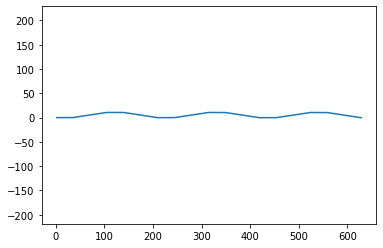

number of data point:  342
cost:  6.753827161871334
fitted function:  5.6327 * sin(0.03 * x + (-2.0686)) + 5.2371


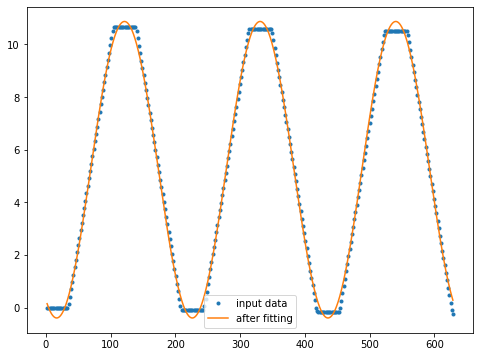

In [38]:
from scipy.optimize import least_squares
import numpy as np

strips = order_segments_by_strips(free_joint_linkage)
all_strip_angle, all_strip_edge_len, all_strip_num_seg, all_extra_first_edge = get_turning_angle_and_length_from_ordered_rods(strips, free_joint_linkage, rest = True)
xs, ys = get_curve_from_angle(all_strip_angle[0], all_strip_edge_len[0])

input_x = xs
input_y = ys

sine_func = lambda x: x[0] * np.sin( x[1] * input_x + x[2] ) + x[3] - input_y
result = least_squares(sine_func, [15, np.pi / 120, -3*np.pi / 12, np.mean(input_y)])
sol = result.x

plot_x = np.arange(min(input_x),max(input_x),0.1)
plot_fitted_y = sol[0]*np.sin(sol[1]*plot_x+sol[2]) + sol[3]


print('number of data point: ', len(input_x))
print('cost: ', result.cost)
print('fitted function: ', '{} * sin({} * x + ({})) + {}'.format(round(sol[0], 4), round(sol[1], 4), round(sol[2], 4), round(sol[3], 4)))
f = plt.figure(1, figsize=(8,6))
ax = f.add_subplot(1,1,1)
plt.plot(input_x, input_y, '.', label='input data')
plt.plot(plot_x, plot_fitted_y, label='after fitting')
# ax.set_aspect('equal')
plt.legend()
plt.show()

## Compute the Laser Cutting Pattern of the Weavers

In [13]:
get_all_curve_pattern(straight_weaver_linkage, RIBBON_CS[1], SUBDIVISION_RESOLUTION, RIBBON_NAME, image_type='png')

../compute_curve_from_curvature.py:248: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')
